# Data Gathering and Preprocessing – MRL Infrared Dataset

This notebook:
- Verifies the MRL infrared eye dataset structure and class balance.
- Explores basic properties such as image counts and resolutions.
- Builds a clean TensorFlow `tf.data` pipeline (train / val / test) with preprocessing and light augmentation.

The goal is to prepare the data pipeline we will reuse for modelling (CNN and later CNN+LSTM).


### Imports and Basic Setup

In [6]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras

print("Python version:", os.sys.version)
print("TensorFlow version:", tf.__version__)

# Optional: check GPU
print("GPUs available:", tf.config.list_physical_devices("GPU"))

2025-12-02 22:37:36.864370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764715057.848735  108851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764715058.148734  108851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764715060.764557  108851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764715060.764596  108851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764715060.764600  108851 computation_placer.cc:177] computation placer alr

Python version: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Path and directories

In [7]:
# Ensure we are in project root
# If this prints something like .../Deep-Learning-Drowsiness-Prediction, we are good.
print("Current working directory:", os.getcwd())

# If needed, uncomment and adjust:
# os.chdir("/mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction")

mrl_root = "Data/MRL/data"
eye_root = "Data/Eye Dataset/train_dataset"  # for later; main focus is MRL

print("MRL root:", os.path.abspath(mrl_root))
print("Eye root:", os.path.abspath(eye_root))

# Collect all MRL image paths
mrl_paths = glob(os.path.join(mrl_root, "**", "*.png"), recursive=True)
print("Total MRL images:", len(mrl_paths))

Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
MRL root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/MRL/data
Eye root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/Eye Dataset/train_dataset
Total MRL images: 84898


### Counts per class (Awake vs Sleepy) and split

In [8]:
# 3. Image counts per split and class (awake vs sleepy)

import pathlib

def count_images_in_dir(dir_path):
    dir_path = pathlib.Path(dir_path)
    return sum(1 for _ in dir_path.rglob("*.png"))

splits = ["train", "val", "test"]
classes = ["awake", "sleepy"]

rows = []
for split in splits:
    for cls in classes:
        folder = os.path.join(mrl_root, split, cls)
        n = count_images_in_dir(folder)
        rows.append({"split": split, "class": cls, "count": n})

counts_df = pd.DataFrame(rows)
counts_df["total_in_split"] = counts_df.groupby("split")["count"].transform("sum")
counts_df["class_ratio"] = counts_df["count"] / counts_df["total_in_split"]

counts_df

,split,class,count,total_in_split,class_ratio
0,train,awake,25770,50937,0.505919
1,train,sleepy,25167,50937,0.494081
2,val,awake,8591,16980,0.505948
3,val,sleepy,8389,16980,0.494052
4,test,awake,8591,16981,0.505918
5,test,sleepy,8390,16981,0.494082


### Image resolution exploration


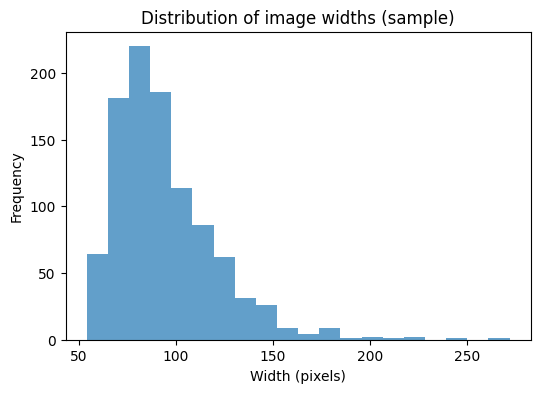

In [10]:
import random

sample_paths = random.sample(mrl_paths, k=min(1000, len(mrl_paths)))

sizes = []
for path in sample_paths:
    with Image.open(path) as img:
        sizes.append(img.size)  # (width, height)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df["count"] = 1

size_counts = (
    sizes_df
    .groupby(["width", "height"])["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)

size_counts.head(10)


plt.figure(figsize=(6,4))
plt.hist(sizes_df["width"], bins=20, alpha=0.7)
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of image widths (sample)")
plt.show()

### Examples of images

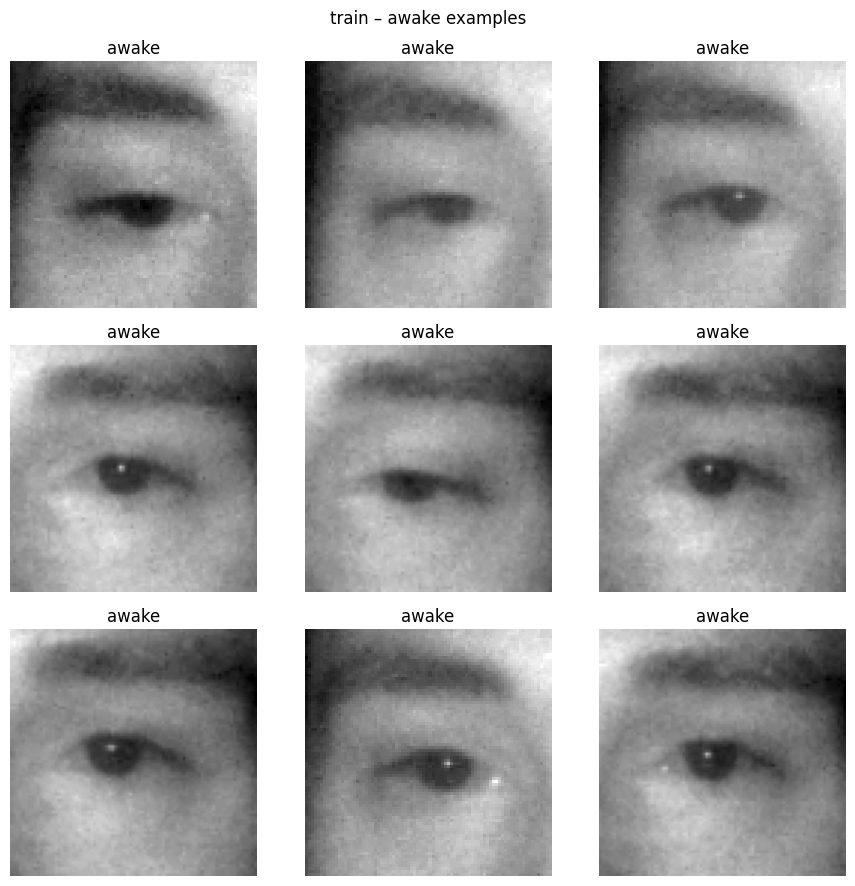

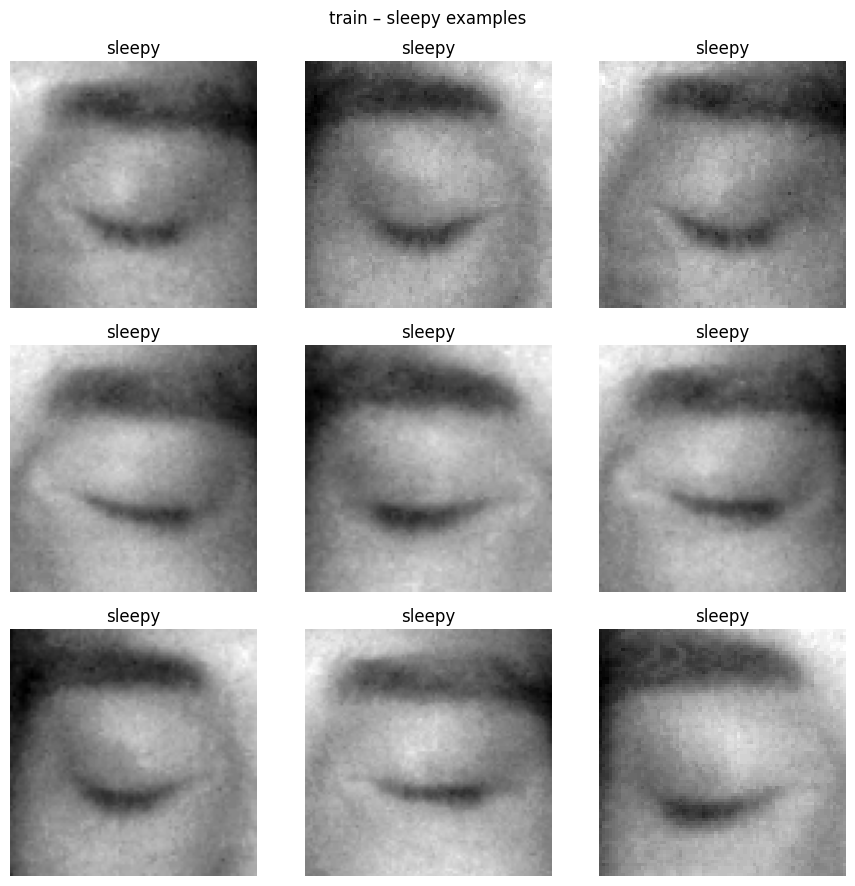

In [11]:
def show_examples(split="train", cls="awake", n=9):
    folder = os.path.join(mrl_root, split, cls)
    paths = glob(os.path.join(folder, "*.png"))
    paths = paths[:n]

    cols = 3
    rows = int(np.ceil(len(paths) / cols))
    plt.figure(figsize=(3*cols, 3*rows))

    for i, p in enumerate(paths):
        with Image.open(p) as img:
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(cls)

    plt.suptitle(f"{split} – {cls} examples")
    plt.tight_layout()
    plt.show()

show_examples("train", "awake", n=9)
show_examples("train", "sleepy", n=9)

### Tensorflow Datasets

In [12]:
IMG_SIZE = (64, 64)   # design choice: small but enough detail
BATCH_SIZE = 64

train_dir = os.path.join(mrl_root, "train")
val_dir   = os.path.join(mrl_root, "val")
test_dir  = os.path.join(mrl_root, "test")

base_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)

base_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE
)

base_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class names:", base_train_ds.class_names)

for images, labels in base_train_ds.take(1):
    print("Raw image batch shape:", images.shape)
    print("Raw label batch shape:", labels.shape)
    break

Found 50937 files belonging to 2 classes.


I0000 00:00:1764715484.486413  108851 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 16980 files belonging to 2 classes.
Found 16981 files belonging to 2 classes.
Class names: ['awake', 'sleepy']
Raw image batch shape: (64, 64, 64, 1)
Raw label batch shape: (64, 1)


### Preprocessing and Augmentation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Light augmentations: only for training
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
])

def preprocess(image, label, training=False):
    # uint8 [0,255] -> float32 [0,1]
    image = tf.cast(image, tf.float32) / 255.0

    if training:
        image = data_augmentation(image, training=True)

    return image, label

def prepare_dataset(ds, training=False):
    ds = ds.map(
        lambda x, y: preprocess(x, y, training=training),
        num_parallel_calls=AUTOTUNE
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(base_train_ds, training=True)
val_ds   = prepare_dataset(base_val_ds,   training=False)
test_ds  = prepare_dataset(base_test_ds,  training=False)

### Check

2025-12-02 22:53:31.780733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 24 of 1000
2025-12-02 22:53:41.877428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 50 of 1000
2025-12-02 22:54:01.811097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 104 of 1000
2025-12-02 22:54:21.723033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 159 of 1000
2025-12-02 22:54:31.837779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 187 of 1000
2025-12-02 22:54:51.788393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a wh

Preprocessed image batch shape: (64, 64, 64, 1)
Preprocessed label batch shape: (64, 1)
Pixel range: 0.015661319717764854 -> 1.0


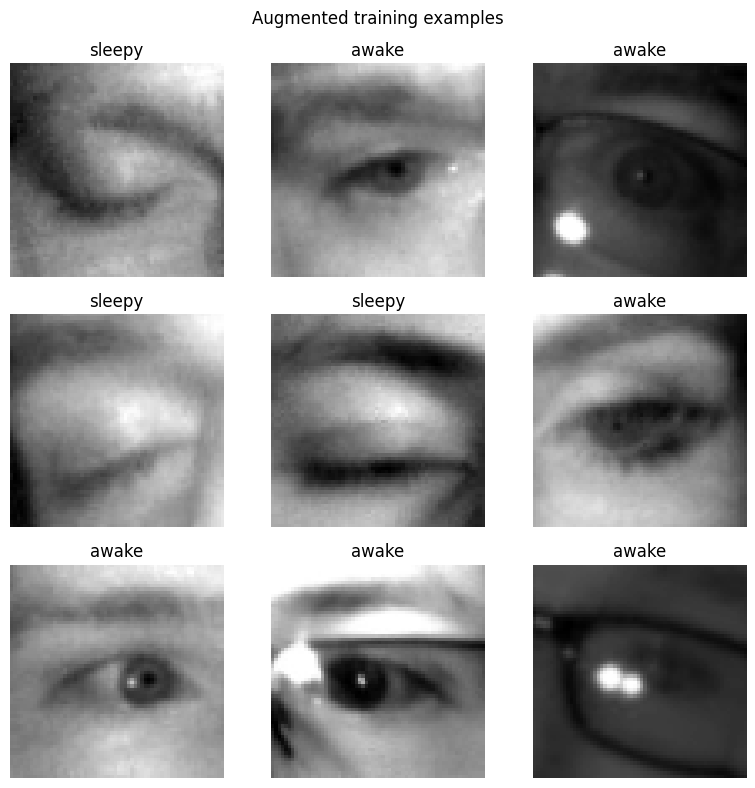

In [14]:
# ==== Sanity check: preprocessed + augmented batch ====

images_batch, labels_batch = next(iter(train_ds))

print("Preprocessed image batch shape:", images_batch.shape)
print("Preprocessed label batch shape:", labels_batch.shape)
print("Pixel range:", float(tf.reduce_min(images_batch)), "->", float(tf.reduce_max(images_batch)))

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_batch[i, :, :, 0], cmap="gray")
    plt.title("awake" if labels_batch[i].numpy() == 0 else "sleepy")
    plt.axis("off")
plt.suptitle("Augmented training examples")
plt.tight_layout()
plt.show()

### NTHUDDD Dataset

In [5]:
# --- Imports you need for this notebook section ---
import os
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# (optional but useful)
import tensorflow as tf
from tensorflow import keras

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# Make sure we are in project root
print("CWD before:", os.getcwd())
if os.path.basename(os.getcwd()) != "Deep-Learning-Drowsiness-Prediction":
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")
print("CWD now:", os.getcwd())

# NTHU root (matches your folder)
nthu_root = "Data/NTHU_DDD/train_data"
print("NTHU root:", os.path.abspath(nthu_root))
print("Subfolders in NTHU:", os.listdir(nthu_root))

2025-12-04 00:27:56.433676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764808077.415268   42861 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764808077.701316   42861 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764808080.272579   42861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764808080.272620   42861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764808080.272623   42861 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CWD before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
CWD now: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
NTHU root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction/Data/NTHU_DDD/train_data
Subfolders in NTHU: ['drowsy', 'notdrowsy']


In [6]:
# --------------------------------------
# Counts per class (drowsy vs notdrowsy)
# --------------------------------------
rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )
    rows.append({"class": cls_name, "count": len(cls_files)})

nthu_counts_df = pd.DataFrame(rows)
nthu_counts_df["total"] = nthu_counts_df["count"].sum()
nthu_counts_df["class_ratio"] = nthu_counts_df["count"] / nthu_counts_df["total"]
nthu_counts_df

,class,count,total,class_ratio
0,drowsy,36030,66521,0.541633
1,notdrowsy,30491,66521,0.458367


Most common resolutions (top 10):


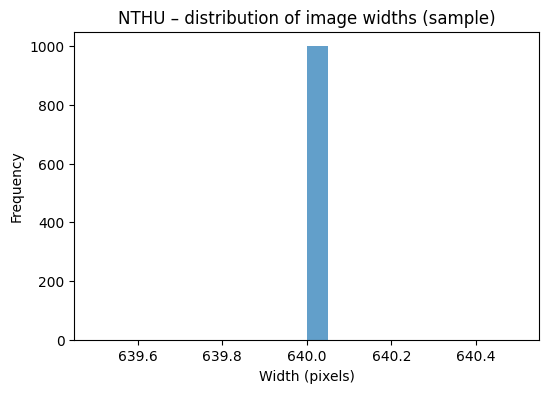

In [7]:
# --------------------------------------
# Image resolution exploration (sample)
# --------------------------------------
import random

sample_paths = random.sample(nthu_paths, k=min(1000, len(nthu_paths)))

sizes = []
for path in sample_paths:
    with Image.open(path) as img:
        sizes.append(img.size)  # (width, height)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
sizes_df["count"] = 1

size_counts = (
    sizes_df
    .groupby(["width", "height"])["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)

print("Most common resolutions (top 10):")
size_counts.head(10)

plt.figure(figsize=(6,4))
plt.hist(sizes_df["width"], bins=20, alpha=0.7)
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.title("NTHU – distribution of image widths (sample)")
plt.show()

### Examples

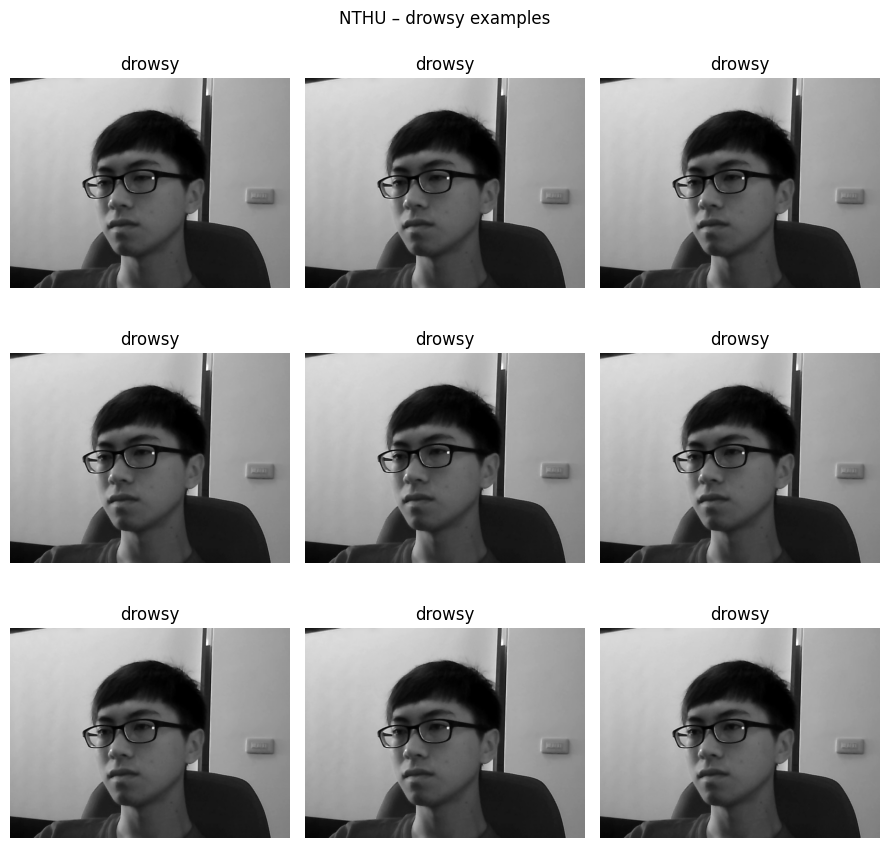

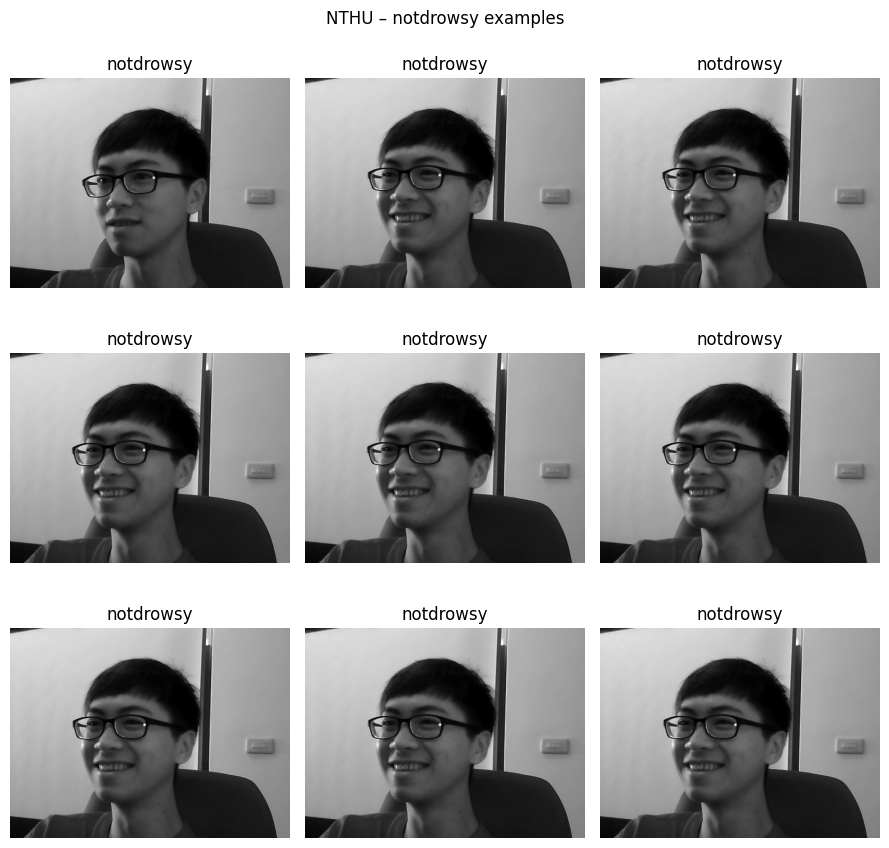

In [8]:
# ------------------------------------------------------------------
# 4) Show some example frames
# ------------------------------------------------------------------
def show_nthu_examples(cls="drowsy", n=9):
    folder = os.path.join(nthu_root, cls)
    paths = (
        glob(os.path.join(folder, "*.png"))
        + glob(os.path.join(folder, "*.jpg"))
        + glob(os.path.join(folder, "*.jpeg"))
    )
    paths = paths[:n]

    cols = 3
    rows = int(np.ceil(len(paths) / cols))
    plt.figure(figsize=(3*cols, 3*rows))

    for i, p in enumerate(paths):
        with Image.open(p) as img:
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(cls)

    plt.suptitle(f"NTHU – {cls} examples")
    plt.tight_layout()
    plt.show()

show_nthu_examples("drowsy", n=9)
show_nthu_examples("notdrowsy", n=9)

In [9]:
# ------------------------------------------------------------------
# 5) TensorFlow datasets (train / val split)
#     We follow the paper: 80% train, 20% test (here: "val")
# ------------------------------------------------------------------
IMG_SIZE = (64, 64)   # resize from 640x480 -> 64x64
BATCH_SIZE = 64

# Use Keras built-in split from folder structure
base_nthu_train_ds = tf.keras.utils.image_dataset_from_directory(
    nthu_root,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.2,    # 80% / 20%
    subset="training",
    seed=42,
)

base_nthu_val_ds = tf.keras.utils.image_dataset_from_directory(
    nthu_root,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
)

print("NTHU class names:", base_nthu_train_ds.class_names)

for images, labels in base_nthu_train_ds.take(1):
    print("Raw NTHU batch image shape:", images.shape)
    print("Raw NTHU batch label shape:", labels.shape)
    break

Found 66521 files belonging to 2 classes.
Using 53217 files for training.


I0000 00:00:1764808681.292945   42861 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 66521 files belonging to 2 classes.
Using 13304 files for validation.
NTHU class names: ['drowsy', 'notdrowsy']
Raw NTHU batch image shape: (64, 64, 64, 1)
Raw NTHU batch label shape: (64, 1)


In [10]:
# ------------------------------------------------------------------
# 6) Preprocessing + augmentation (same style as MRL)
# ------------------------------------------------------------------
AUTOTUNE = tf.data.AUTOTUNE

nthu_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    # we can add brightness/contrast later if needed
])

def nthu_preprocess(image, label, training=False):
    # uint8 [0,255] -> float32 [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    if training:
        image = nthu_augmentation(image, training=True)
    return image, label

def prepare_nthu_dataset(ds, training=False):
    ds = ds.map(
        lambda x, y: nthu_preprocess(x, y, training=training),
        num_parallel_calls=AUTOTUNE,
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

nthu_train_ds = prepare_nthu_dataset(base_nthu_train_ds, training=True)
nthu_val_ds   = prepare_nthu_dataset(base_nthu_val_ds,   training=False)

2025-12-04 00:38:29.057034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 42 of 1000
2025-12-04 00:38:49.034928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 127 of 1000
2025-12-04 00:39:09.128215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 206 of 1000
2025-12-04 00:39:29.055455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 285 of 1000
2025-12-04 00:39:49.102629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 366 of 1000
2025-12-04 00:40:09.007427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a w

Preprocessed NTHU image batch shape: (64, 64, 64, 1)
Preprocessed NTHU label batch shape: (64, 1)
Pixel range: 0.0 -> 0.9934846758842468


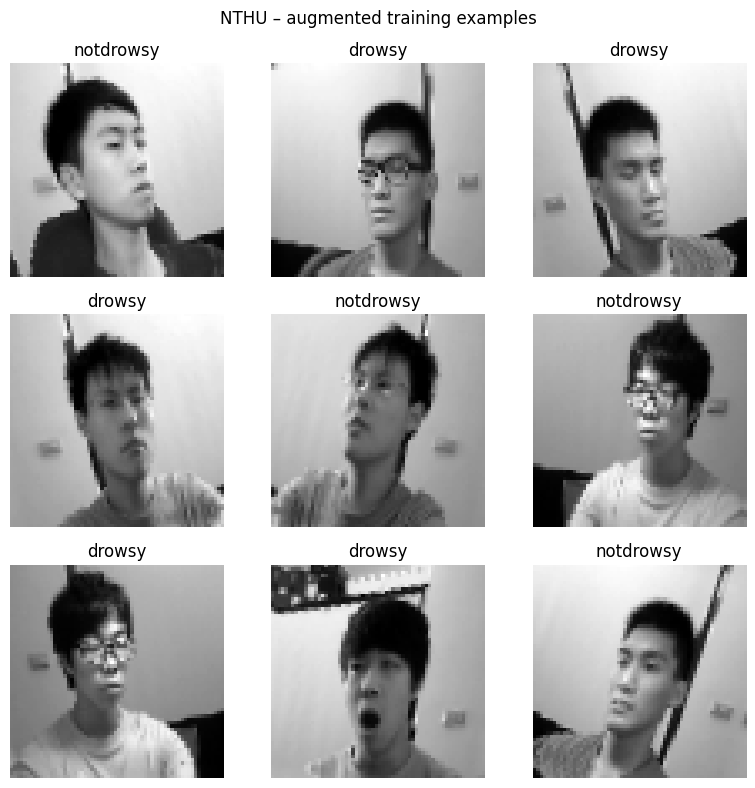

In [11]:
# ------------------------------------------------------------------
# 7) Sanity check: preprocessed batch preview
# ------------------------------------------------------------------
nthu_images_batch, nthu_labels_batch = next(iter(nthu_train_ds))

print("Preprocessed NTHU image batch shape:", nthu_images_batch.shape)
print("Preprocessed NTHU label batch shape:", nthu_labels_batch.shape)
print("Pixel range:",
      float(tf.reduce_min(nthu_images_batch)),
      "->",
      float(tf.reduce_max(nthu_images_batch)))

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(nthu_images_batch[i, :, :, 0], cmap="gray")
    lbl = int(nthu_labels_batch[i].numpy())
    plt.title("drowsy" if lbl == 0 else "notdrowsy")
    plt.axis("off")
plt.suptitle("NTHU – augmented training examples")
plt.tight_layout()
plt.show()

### Summary of test and validation

In [12]:
# =========================================
# NTHU – class balance in train / val split
# =========================================
import numpy as np

def summarize_split(ds, split_name):
    total = 0
    ones  = 0  # label 1 = "notdrowsy" (alphabetical order)
    for _, labels in ds:
        labels_np = labels.numpy().ravel()
        total += labels_np.size
        ones  += labels_np.sum()
    zeros = total - ones
    print(f"\n=== {split_name} split ===")
    print(f"Total samples: {total}")
    print(f"drowsy (label 0):     {int(zeros)}  ({zeros/total:.3%})")
    print(f"notdrowsy (label 1):  {int(ones)}   ({ones/total:.3%})")

summarize_split(base_nthu_train_ds, "NTHU train (80%)")
summarize_split(base_nthu_val_ds,   "NTHU val (20%)")

2025-12-04 00:47:44.535172: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



=== NTHU train (80%) split ===
Total samples: 53217
drowsy (label 0):     28728  (53.983%)
notdrowsy (label 1):  24489   (46.017%)

=== NTHU val (20%) split ===
Total samples: 13304
drowsy (label 0):     7302  (54.886%)
notdrowsy (label 1):  6002   (45.114%)


2025-12-04 00:48:30.254097: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
from glob import glob
from pathlib import Path

some_paths = glob(os.path.join(nthu_root, "drowsy", "*"))[:10]
some_paths += glob(os.path.join(nthu_root, "notdrowsy", "*"))[:10]

for p in some_paths:
    print(Path(p).name)

001_glasses_sleepyCombination_1000_drowsy.jpg
001_glasses_sleepyCombination_1001_drowsy.jpg
001_glasses_sleepyCombination_1002_drowsy.jpg
001_glasses_sleepyCombination_1003_drowsy.jpg
001_glasses_sleepyCombination_1004_drowsy.jpg
001_glasses_sleepyCombination_1005_drowsy.jpg
001_glasses_sleepyCombination_1006_drowsy.jpg
001_glasses_sleepyCombination_1007_drowsy.jpg
001_glasses_sleepyCombination_1008_drowsy.jpg
001_glasses_sleepyCombination_1009_drowsy.jpg
001_glasses_nonsleepyCombination_0_notdrowsy.jpg
001_glasses_nonsleepyCombination_1000_notdrowsy.jpg
001_glasses_nonsleepyCombination_1001_notdrowsy.jpg
001_glasses_nonsleepyCombination_1002_notdrowsy.jpg
001_glasses_nonsleepyCombination_1003_notdrowsy.jpg
001_glasses_nonsleepyCombination_1004_notdrowsy.jpg
001_glasses_nonsleepyCombination_1005_notdrowsy.jpg
001_glasses_nonsleepyCombination_1006_notdrowsy.jpg
001_glasses_nonsleepyCombination_1007_notdrowsy.jpg
001_glasses_nonsleepyCombination_1008_notdrowsy.jpg


In [14]:
from pathlib import Path
import pandas as pd
from glob import glob
import os

def parse_nthu_name(path_str):
    """
    Parse NTHU filename like:
      001_glasses_sleepyCombination_1000_drowsy.jpg
    into subject, accessory, scenario, sequence_id, frame_idx, label_from_name
    """
    name = Path(path_str).stem  # drop extension
    parts = name.split("_")

    # safety check in case something odd appears
    if len(parts) < 5:
        # fallback: treat as unknown sequence
        return {
            "filepath": path_str,
            "subject": "unknown",
            "accessory": "unknown",
            "scenario": "unknown",
            "sequence_id": "unknown",
            "frame_idx": -1,
            "label_from_name": "unknown",
        }

    subject_id       = parts[0]          # '001'
    accessory        = parts[1]          # 'glasses', maybe 'noglasses'
    scenario         = parts[2]          # 'sleepyCombination', 'nonsleepyCombination', etc.
    frame_idx        = int(parts[3])     # 1000, 1001, ...
    label_from_name  = parts[4]          # 'drowsy' or 'notdrowsy'

    # sequence id = (subject, accessory, scenario)
    sequence_id = "_".join(parts[:3])

    return {
        "filepath": path_str,
        "subject": subject_id,
        "accessory": accessory,
        "scenario": scenario,
        "sequence_id": sequence_id,
        "frame_idx": frame_idx,
        "label_from_name": label_from_name,
    }

# Build metadata table for ALL images under NTHU_DDD/train_data
rows = []
for cls_name in ["drowsy", "notdrowsy"]:
    cls_folder = os.path.join(nthu_root, cls_name)
    cls_files = (
        glob(os.path.join(cls_folder, "*.png"))
        + glob(os.path.join(cls_folder, "*.jpg"))
        + glob(os.path.join(cls_folder, "*.jpeg"))
    )

    for f in cls_files:
        info = parse_nthu_name(f)
        # folder label as 0/1 (0 = drowsy, 1 = notdrowsy)
        info["label"] = 0 if cls_name == "drowsy" else 1
        rows.append(info)

nthu_meta = pd.DataFrame(rows)
nthu_meta.head()

,filepath,subject,accessory,scenario,sequence_id,frame_idx,label_from_name,label
0,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1000,drowsy,0
1,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1001,drowsy,0
2,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1002,drowsy,0
3,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1003,drowsy,0
4,Data/NTHU_DDD/train_data/drowsy/001_glasses_sl...,001,glasses,sleepyCombination,001_glasses_sleepyCombination,1004,drowsy,0


In [15]:
# How many frames in each (subject, accessory, scenario) sequence?
seq_counts = (
    nthu_meta.groupby(["sequence_id", "label"])["frame_idx"]
    .count()
    .reset_index()
    .rename(columns={"frame_idx": "num_frames"})
    .sort_values("num_frames", ascending=False)
)

seq_counts.head(10)
print("Number of unique sequences:", seq_counts["sequence_id"].nunique())
print("Min / Max frames per sequence:",
      seq_counts["num_frames"].min(), "/", seq_counts["num_frames"].max())

Number of unique sequences: 27
Min / Max frames per sequence: 95 / 3330


In [16]:
mismatch = nthu_meta[nthu_meta["label_from_name"] != nthu_meta["label"].map({0:"drowsy",1:"notdrowsy"})]
print("Mismatched label count:", len(mismatch))
mismatch.head()

Mismatched label count: 0


,filepath,subject,accessory,scenario,sequence_id,frame_idx,label_from_name,label
